# Implementing a CNN neural network on CIFAR10 data set

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary

In [3]:
base_path = "/content/drive/My Drive/Colab Notebooks/Hardware_AI/CA1"

## Download CIFAR10 data set

In [4]:
trainset_raw = CIFAR10(root= base_path+'/train', train=True, download=True)

testset_raw = CIFAR10(root= base_path +'/test', train=False, download=True)

## Distribution of classes

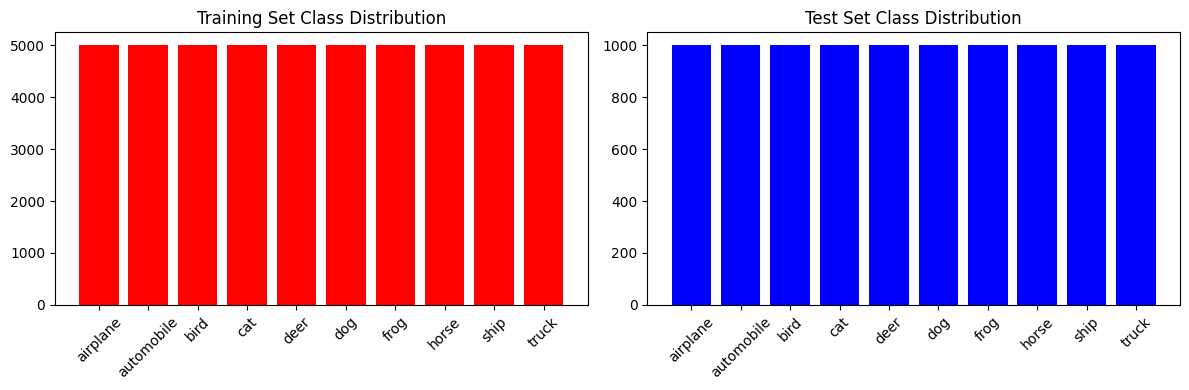

In [5]:
class_names = trainset_raw.classes

train_labels = [label for _, label in trainset_raw]
test_labels = [label for _, label in testset_raw]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

train_distribution = [train_counts[i] for i in range(10)]
test_distribution = [test_counts[i] for i in range(10)]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(class_names, train_distribution, color='r')
axs[0].set_title("Training Set Class Distribution")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(class_names, test_distribution, color='b')
axs[1].set_title("Test Set Class Distribution")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Mean and STD of channels

In [6]:
imgs = torch.stack([torch.tensor(np.array(img)).permute(2, 0, 1) / 255.0 for img, _ in trainset_raw], dim=0)

mean = imgs.mean(dim=(0, 2, 3))
std = imgs.std(dim=(0, 2, 3))

print(f"Mean: {mean}")
print(f"Std:  {std}")


Mean: tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


## Loading Train, validation and test batches

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_val_ratio = 0.9

train_size = int(train_val_ratio * len(trainset_raw))
val_size = len(trainset_raw) - train_size
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(trainset_raw, [train_size, val_size], generator=generator)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform

testset = datasets.CIFAR10(root=base_path + '/test', train=False, download=True, transform=val_test_transform)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")


Train samples: 45000
Validation samples: 5000
Test samples: 10000


## Plot one of the batches

In [8]:
def unnormalize(img_tensor, mean, std):

    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return img_tensor * std + mean


<ipython-input-8-e338b97241f1>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).reshape(3, 1, 1)
<ipython-input-8-e338b97241f1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).reshape(3, 1, 1)


Train batch


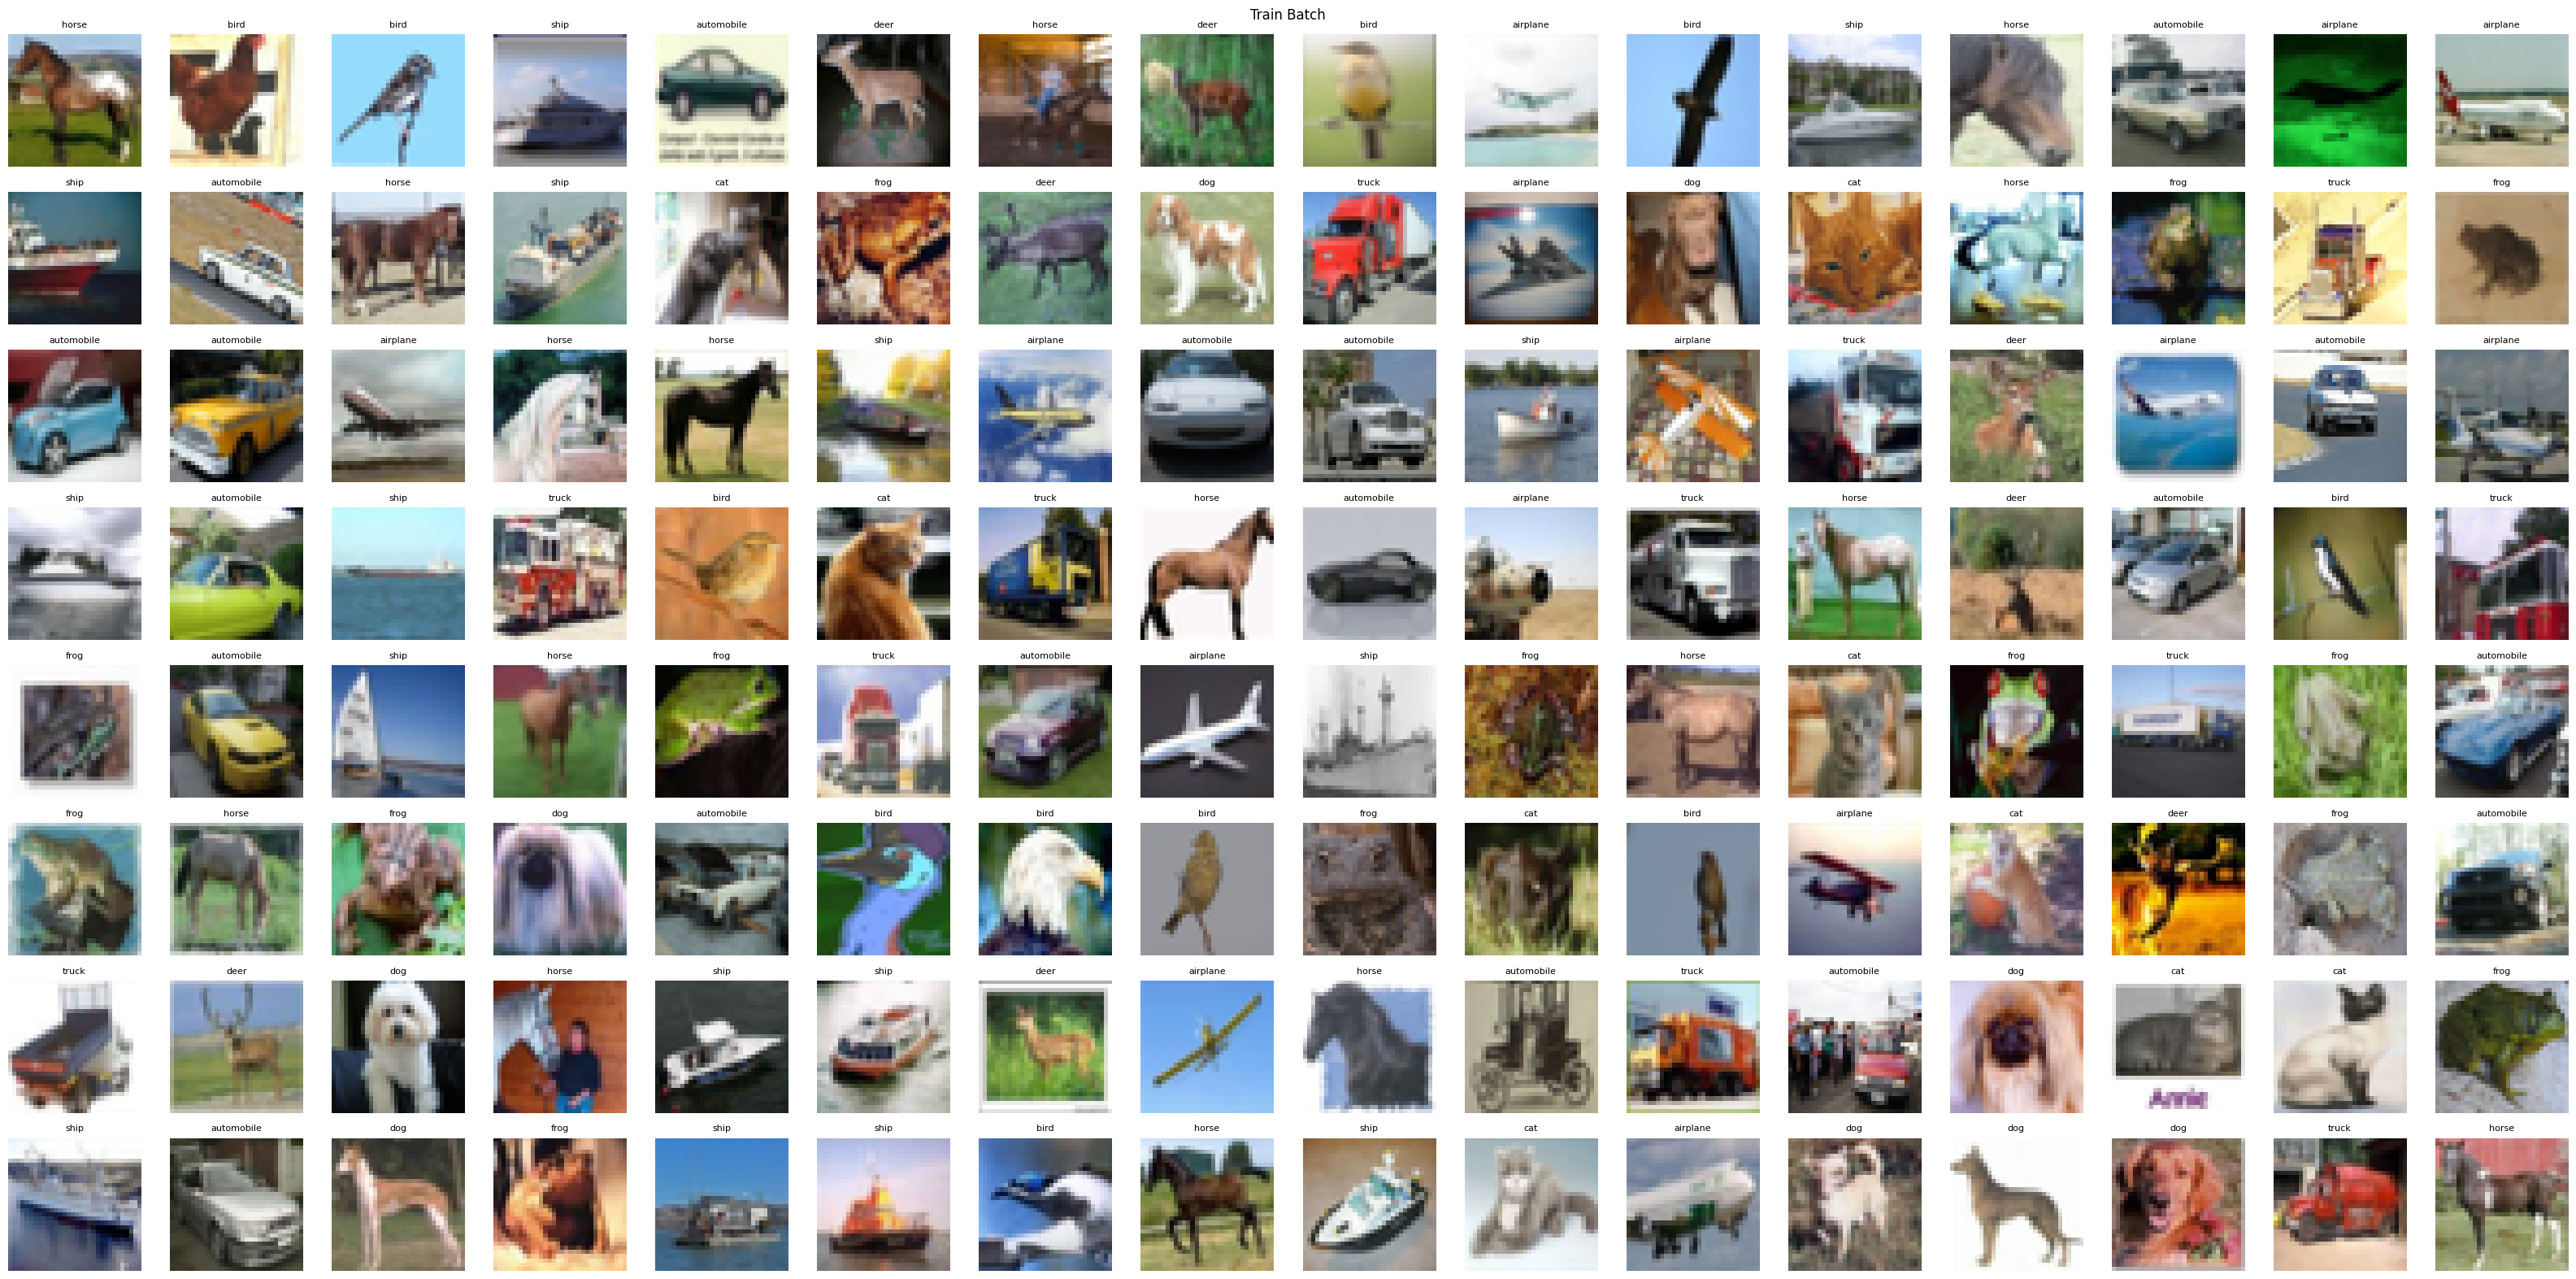

Test batch


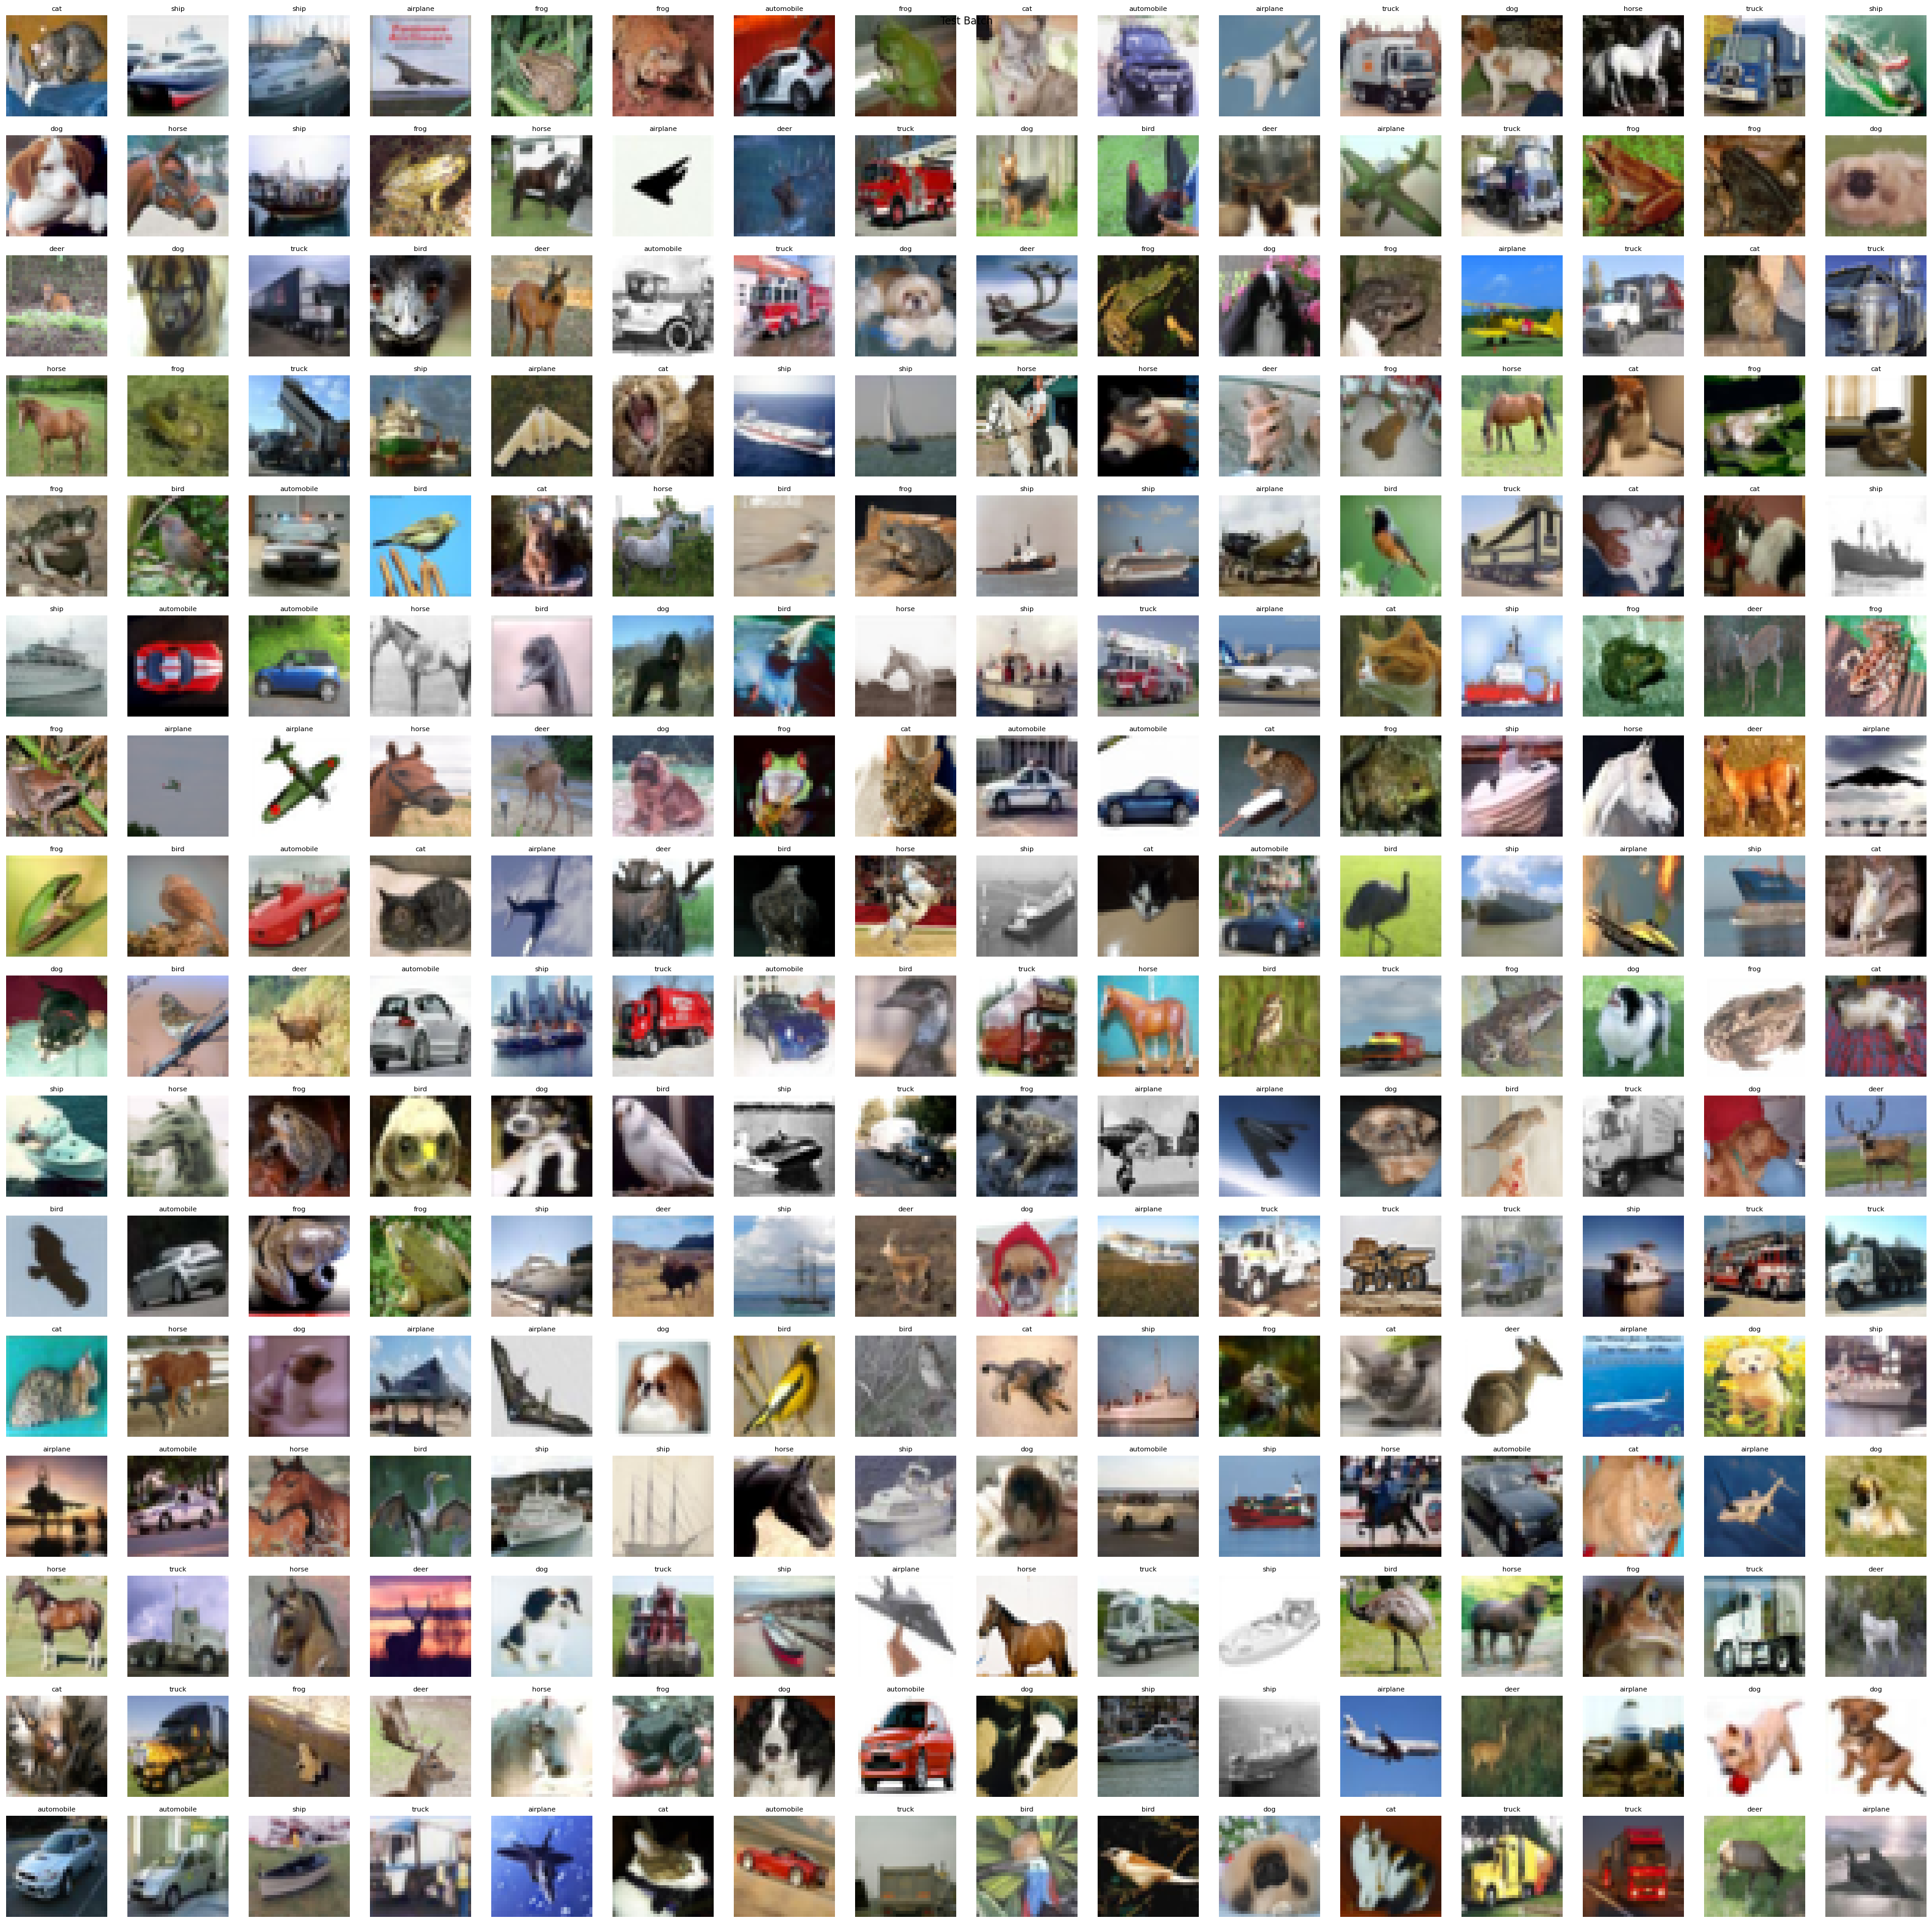

In [9]:
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

train_images, train_labels = train_batch
test_images, test_labels = test_batch

train_images = unnormalize(train_images, mean, std)
test_images = unnormalize(test_images, mean, std)

def plot_batch(images, labels, class_names, title):
    batch_size = images.shape[0]
    cols = 16
    rows = (batch_size + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(batch_size):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        label = class_names[labels[i]]

        axes[i].imshow(img)
        axes[i].set_title(label, fontsize=8)
        axes[i].axis("off")

    for j in range(batch_size, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Train batch")
plot_batch(train_images, train_labels, class_names, "Train Batch")
print("Test batch")
plot_batch(test_images, test_labels, class_names, "Test Batch")


## Define model

In [26]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes)
            #nn.ReLU(),
            #nn.Dropout(0.25),
            #nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [27]:
model = CNNModel()

In [28]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
print(f"Approx. size: {total_params * 4 / (1024 * 1024):.2f} MB")

Total parameters: 1188170
Approx. size: 4.53 MB


## Training Model

In [12]:
def train_model(model, train_loader, val_loader, num_epochs=50, patience=7, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_loss = float('inf')
    best_model_state = None
    early_stop_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / total
        val_acc = correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step(avg_val_loss)

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 2.3344 | Val Loss: 1.7708 | Train Acc: 0.3301 | Val Acc: 0.4112
Epoch 2/50 | Train Loss: 1.3871 | Val Loss: 1.1819 | Train Acc: 0.5064 | Val Acc: 0.5806
Epoch 3/50 | Train Loss: 1.1001 | Val Loss: 1.0026 | Train Acc: 0.6053 | Val Acc: 0.6436
Epoch 4/50 | Train Loss: 0.9208 | Val Loss: 0.8518 | Train Acc: 0.6743 | Val Acc: 0.6960
Epoch 5/50 | Train Loss: 0.7867 | Val Loss: 0.7496 | Train Acc: 0.7250 | Val Acc: 0.7310
Epoch 6/50 | Train Loss: 0.6974 | Val Loss: 0.7315 | Train Acc: 0.7560 | Val Acc: 0.7390
Epoch 7/50 | Train Loss: 0.6336 | Val Loss: 0.5997 | Train Acc: 0.7801 | Val Acc: 0.7906
Epoch 8/50 | Train Loss: 0.5808 | Val Loss: 0.6113 | Train Acc: 0.7974 | Val Acc: 0.7752
Epoch 9/50 | Train Loss: 0.5245 | Val Loss: 0.6623 | Train Acc: 0.8162 | Val Acc: 0.7788
Epoch 10/50 | Train Loss: 0.4804 | Val Loss: 0.5194 | Train Acc: 0.8328 | Val Acc: 0.8184
Epoch 11/50 | Train Loss: 0.4459 | Val Loss: 0.5571 | Train Acc: 0.8443 | Val Acc: 0.8116
Epoch 12/50 | Train

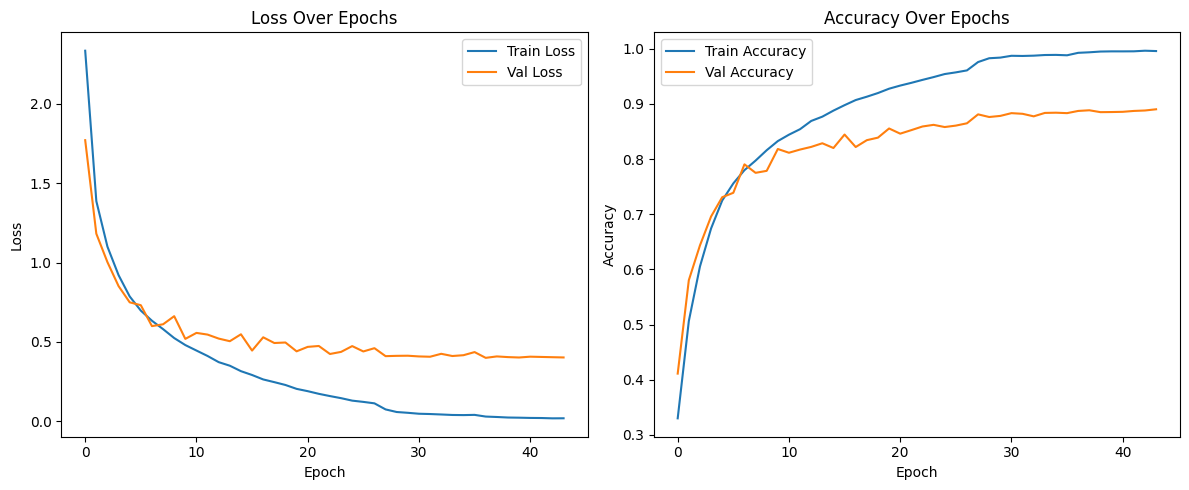

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train_model(model, train_loader, val_loader, device=device)

In [31]:
torch.save(model.state_dict(), base_path + "/cnn_model.pth")

In [ ]:
## model.load_state_dict(torch.load(base_path + "/cnn_model.pth"))

## Model Evaluation

Accuracy: 0.8844
              precision    recall  f1-score   support

    airplane     0.8830    0.8980    0.8904      1000
  automobile     0.9481    0.9320    0.9400      1000
        bird     0.8820    0.8070    0.8428      1000
         cat     0.8173    0.7560    0.7855      1000
        deer     0.8415    0.9130    0.8758      1000
         dog     0.8315    0.8290    0.8302      1000
        frog     0.8926    0.9230    0.9076      1000
       horse     0.9127    0.9200    0.9163      1000
        ship     0.9155    0.9420    0.9285      1000
       truck     0.9176    0.9240    0.9208      1000

    accuracy                         0.8844     10000
   macro avg     0.8842    0.8844    0.8838     10000
weighted avg     0.8842    0.8844    0.8838     10000



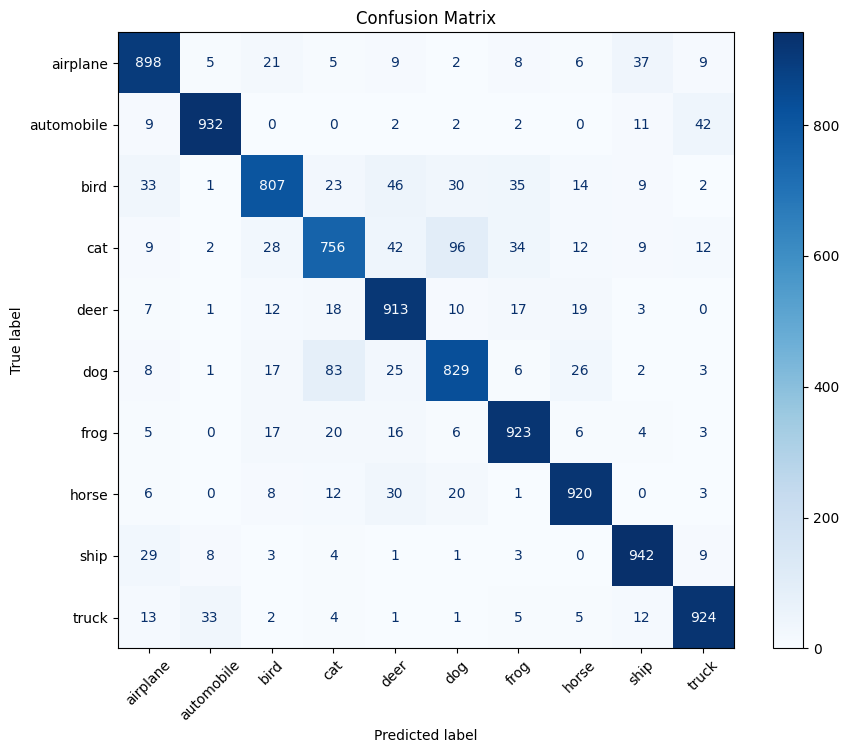

In [32]:
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy:", accuracy)

print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## Model Summary

In [33]:
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Dropout: 2-8                      [1, 64, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 16, 16]          256
│    └─ReLU: 2-11                        [1, 128, 16, 16]          --
│